In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

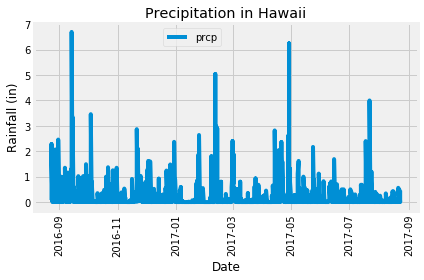

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent = session.query(Measurement).order_by(Measurement.date.desc()).limit(1)
for date in recent:
    most_recent = date.date
    
most_recent = dt.datetime.strptime(most_recent, '%Y-%m-%d')
#print(most_recent)

# Calculate the date 1 year ago from the last data point in the database
year_ago = most_recent - dt.timedelta(days=365)
#print(year_ago)

# Perform a query to retrieve the data and precipitation scores
precip_scores = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).\
order_by(Measurement.date).all()
#print(precip_scores)

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_date = pd.DataFrame(precip_scores).dropna()
#print(precip_date)

# Sort the dataframe by date
precip_date['date'] = pd.to_datetime(precip_date['date'])
#print(precip_date)

# Use Pandas Plotting with Matplotlib to plot the data

plt.plot(precip_date['date'], precip_date['prcp'])
plt.legend(bbox_to_anchor=(0.5,1.00))
plt.title('Precipitation in Hawaii')
plt.xticks(rotation='90')
plt.xlabel('Date')
plt.ylabel('Rainfall (in)')
plt.yticks(range(8))
plt.tight_layout()
plt.savefig('Precipitation in Hawaii.png')


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_date.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(f'There are {stations} stations in the dataset.')

There are 9 stations in the dataset.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#temp_table = pd.Dataframe(), columns = [Low-Temp, High-Temp, Avg-Temp]

active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()

temp_table = pd.DataFrame(active_station, columns=["Low_temp", "Avg_temp", "High_temp"])
temp_table

,Low_temp,Avg_temp,High_temp
0,54.0,85.0,71.663781


In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

active_station_tobs = session.query(Measurement.tobs).filter(Measurement.date >= year_ago, Measurement.station == 'USC00519281').all()
#active_station_tobs

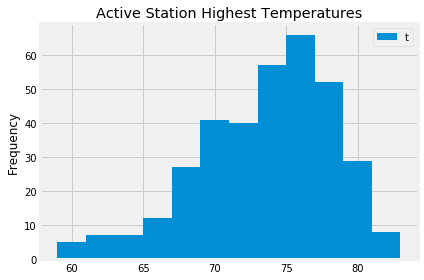

In [16]:
x = [x[0] for x in active_station_tobs]

plt.hist(x, bins=12)
plt.legend('tobs')
plt.title('Active Station Highest Temperatures')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('Active Station Highest Temps.png')
plt.show()

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp = calc_temps('2017-08-06', '2017-08-16')
temp

[(70.0, 78.8913043478261, 84.0)]

In [19]:
temp_df = pd.DataFrame(temp, columns=["min_temp", "avg_temp", "max_temp"])
temp_df

,min_temp,avg_temp,max_temp
0,70.0,78.891304,84.0


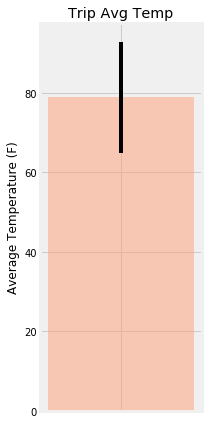

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_temp = temp_df['min_temp']
avg_temp = temp_df['avg_temp']
max_temp = temp_df['max_temp']
  
plt.figure(figsize=(3,6))
plt.bar(1, avg_temp, yerr= max_temp - min_temp, tick_label="", color="lightsalmon", alpha=0.5)
plt.title('Trip Avg Temp')
plt.ylabel('Average Temperature (F)')
plt.tight_layout()
plt.savefig('Trip Temps')

In [21]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def rainfall(start_date, end_date):
    return session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                        group_by(Measurement.station).join(Station, Measurement.station == Station.station).filter(Measurement.date>= start_date).\
                        filter(Measurement.date <= end_date).order_by('prcp desc').all()
rainfall('2017-08-06', '2017-08-16')        

[('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.11),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.44),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.02),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.21000000000000002),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.81)]

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [25]:
# Plot the daily normals as an area plot with `stacked=False`
